In [26]:
import numpy as np
import pandas as pd
import re
import os

import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline

In [27]:
list_of_tuples = []
for filename in os.listdir("babynames"):
    if "txt" in filename: 
        year = int(re.search(r'\d+', filename).group())
        with open("babynames/" + filename, "r") as file:
            file_content = file.readlines()
            for string in file_content:
                data_str = [year]
                data_from_file = string.strip().split(',')
                # Преобразуем количество имён в число! Иначе потом оно интерпретируется как строка,
                # и всё получается неправильно
                data_from_file_convert = []
                data_from_file_convert.append(data_from_file[0])
                data_from_file_convert.append(data_from_file[1])
                data_from_file_convert.append(int(data_from_file[2])) # преобразование в число
                data_str.extend(data_from_file_convert)
                data_str_tuple = tuple(data_str)
                list_of_tuples.append(data_str_tuple)

df = pd.DataFrame.from_records(list_of_tuples, columns=['year','name','gender','count'])

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690784 entries, 0 to 1690783
Data columns (total 4 columns):
year      1690784 non-null int64
name      1690784 non-null object
gender    1690784 non-null object
count     1690784 non-null int64
dtypes: int64(2), object(2)
memory usage: 64.5+ MB


In [29]:
df.head()

,year,name,gender,count
0,2004,Emily,F,25009
1,2004,Emma,F,21591
2,2004,Madison,F,20607
3,2004,Olivia,F,16098
4,2004,Hannah,F,15593


**Сгруппируйте данные по году и полу и визуализируйте общую динамику рождаемости обоих полов**

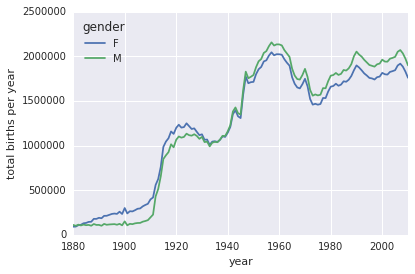

In [30]:
sns.set()
df.pivot_table('count', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year')

**Найдите самые популярные имена за всю историю**

In [31]:
df.groupby('name').sum().sort_values(['count'], ascending=False)['count'].head(15)

name
James          5072771
John           5061897
Robert         4788050
Michael        4265373
Mary           4119074
William        4002392
David          3538748
Richard        2552269
Joseph         2529809
Charles        2347703
Thomas         2263138
Christopher    1957344
Daniel         1818134
Patricia       1573706
Elizabeth      1566981
Name: count, dtype: int64

**Разбейте весь временной промежуток в данных на 10 частей и для каждой найдите самое популярное имя каждого пола. Для каждого найденного имени визуализируйте его динамику за всё время**

In [32]:
year_max = 2010
year_min = 1880
n_parts = 10

delta_year = (year_max - year_min)//n_parts

most_popular_names_male = set()  # т.к. имена повторяются, то создаём множества
most_popular_names_female = set()
# находим интервалы годов для поиска самого популярного имени
for i in range(0, n_parts):
    from_year = year_min + i*delta_year
    if i < n_parts - 1:
        to_year = from_year + delta_year - 1
    else:
        to_year = from_year + delta_year
    
    df_interval_male = df[(df['year'] >= from_year) & (df['year'] <= to_year) & (df['gender'] == 'M')]
    df_interval_female = df[(df['year'] >= from_year) & (df['year'] <= to_year) & (df['gender'] == 'F')]
    
    # самое популярное имя в каждом периоде для каждого пола
    name_male = df_interval_male.groupby('name').sum().sort_values(['count'], ascending=False)['count'].head(1)
    most_popular_names_male.add(name_male.index.tolist()[0])
    
    name_female = df_interval_female.groupby('name').sum().sort_values(['count'], ascending=False)['count'].head(1)
    most_popular_names_female.add(name_female.index.tolist()[0])

print(most_popular_names_male)
print(most_popular_names_female)

{'James', 'Jacob', 'John', 'Michael', 'Robert'}
{'Linda', 'Emily', 'Lisa', 'Jennifer', 'Mary', 'Jessica'}


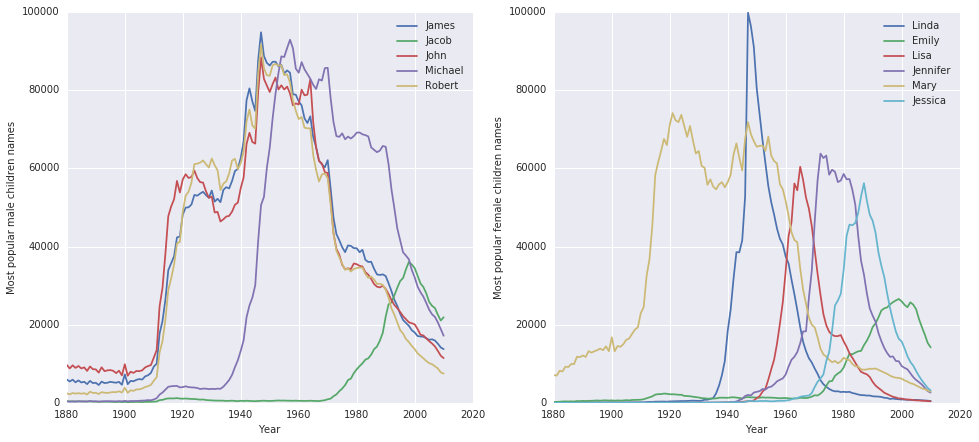

In [33]:
fig, ax1 = plt.subplots(1,2, figsize=(16,7))

ax1[0].set_xlabel('Year', fontsize = 10)
ax1[0].set_ylabel('Most popular male children names', fontsize = 10)

ax1[1].set_xlabel('Year', fontsize = 10)
ax1[1].set_ylabel('Most popular female children names', fontsize = 10)

for male_name in most_popular_names_male:
    ax1[0].plot(df[df['name'] == male_name].groupby('year').sum(), label = male_name)
ax1[0].legend(loc=1, fontsize=10, frameon=False)

for female_name in most_popular_names_female:
    ax1[1].plot(df[df['name'] == female_name].groupby('year').sum(), label = female_name)
ax1[1].legend(loc=1, fontsize=10, frameon=False)

**Для каждого года рассчитайте сколько имён покрывают 50% людей, визуализируйте (мы увидим разнообразие имён за каждый год)**

In [34]:
birth_rate = df.groupby('year').sum()['count'].values  # общая рождаемость за каждый год

half_of_population_names = []

# Цикл по годам
for index, year in enumerate(range(1880, 2011)):
    df_year = df[df['year'] == year]  # выборка для года
    overall_count_in_year = birth_rate[index]
    
    popular_names_table = df_year.groupby('name').sum().sort_values(['count'], ascending=False)['count']
    
    popular_names = popular_names_table.index.tolist()
    popular_names_count = popular_names_table.values
    
    # суммируем количества по популярным именам, пока не получим 50 % от общей рождаемости
    names_count = 0
    sum_by_popular_names = 0
    
    for count_by_name in popular_names_count:
        sum_by_popular_names += count_by_name
        names_count += 1
        if sum_by_popular_names >= 0.5*overall_count_in_year:
            break
    
    half_of_population_names.append(names_count)

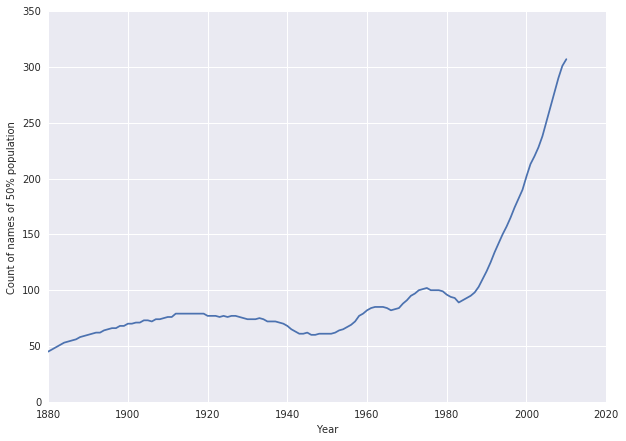

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.set_xlabel('Year', fontsize = 10)
ax.set_ylabel('Count of names of 50% population', fontsize = 10)

ax.plot(range(1880, 2011), half_of_population_names)

**Выберите 4 года из всего промежутка и отобразите для каждого года распределение по первой букве в имени, по последней букве в имени**

In [36]:
years = [1890, 1920, 1960, 2000]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


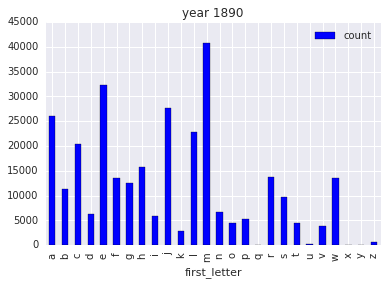

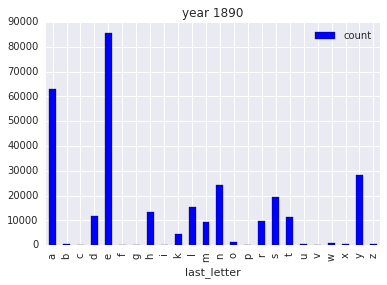

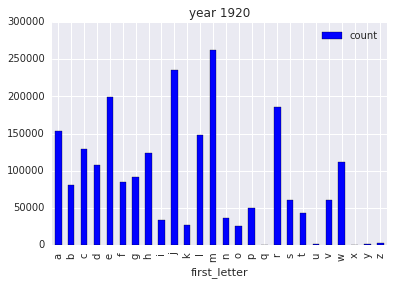

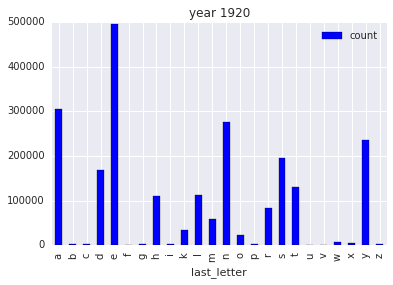

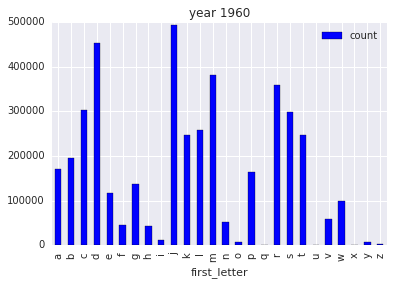

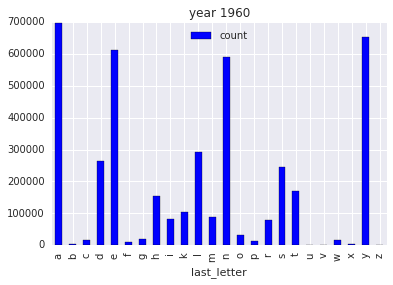

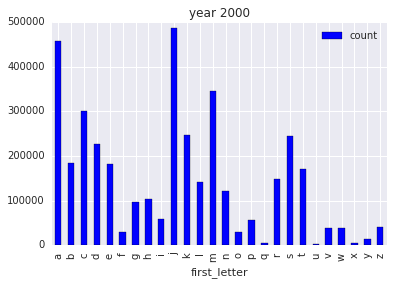

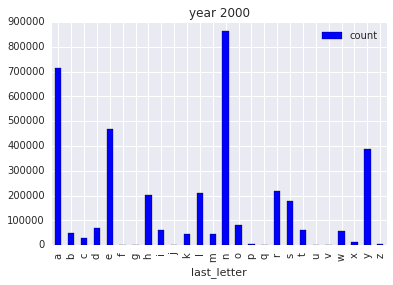

In [37]:
from string import ascii_lowercase
from string import ascii_uppercase

for year in years:    
    df_year = df[df['year'] == year]
    
    df_year['first_letter'] = df_year['name'].apply(lambda x: x[0].lower())  # первая буква имени
    df_year['last_letter'] = df_year['name'].apply(lambda x: x[-1])   # последняя буква имени

    df_first_letter = df_year[['count', 'first_letter']]
    df_last_letter = df_year[['count', 'last_letter']]

    # группируем имена по первой и последней букве и строим диаграмму
    df_first_letter.groupby('first_letter').sum().plot.bar(title='year %d' % year)
    df_last_letter.groupby('last_letter').sum().plot.bar(title='year %d' % year)

**Составьте список из нескольких известных людей (президенты, певцы, актёры, киногерои) и оцените их влияние на динамику имён, постройте наглядную визуализацию**

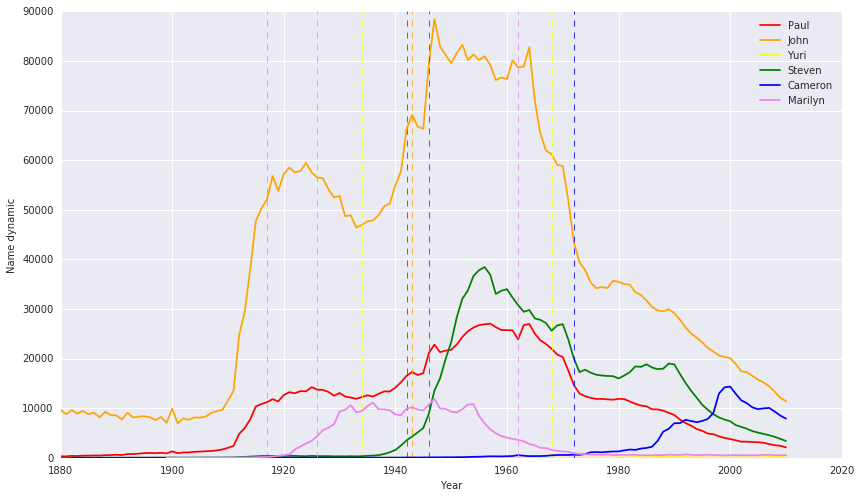

In [38]:
famous_names = ['Paul McCartney', 'John Kennedy', 'Yuri Gagarin', 'Steven Spielberg',
               'Cameron Diaz', 'Marilyn Monroe']
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']

# Годы жизни
born_year = [1942, 1917, 1934, 1946, 1972, 1926]
death_year = [0, 1943, 1968, 0, 0, 1962]

fig, ax1 = plt.subplots(1,1, figsize=(14,8))

ax1.set_xlabel('Year', fontsize = 10)
ax1.set_ylabel('Name dynamic', fontsize = 10)

# Отобразим динамику имени и (вертикальными линиями) годы жизни известного человека
for index, famous_name in enumerate(famous_names):
    name = famous_name.split(' ')[0]  # Имя
    ax1.plot(df[df['name'] == name].groupby('year').sum(), label = name, color=colors[index])
    ax1.axvline(born_year[index], color=colors[index], linestyle='--', linewidth=0.8)
    if death_year[index] > 0:
        ax1.axvline(death_year[index], color=colors[index], linestyle='--', linewidth=0.8)
ax1.legend(loc=1, fontsize=10, frameon=False)